<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/3_investigate_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/yilmajung/belief_and_llms_v0/blob/main/3_investigate_correlations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Phase 3: Investigate Demographic Vector Correlations

**Goal:** Investigate how steering with one demographic vector affects other demographic representations.

**Key Questions:**
1. When we inject a "Republican" steering vector, how do other demographic similarities change?
2. Are there clusters of demographics that move together?
3. Can we identify "entangled" vs "independent" demographic dimensions?

In [1]:
!pip install -q -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 44.1 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Link to Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Configuration
BASE_DIR = "/content/drive/MyDrive/belief_and_llms_v0"
VECTOR_DIR = os.path.join(BASE_DIR, "vectors")

# Load demographic vectors
vectors_path = os.path.join(VECTOR_DIR, "gss_demogaphic_vectors.pt")
demographic_vectors = torch.load(vectors_path)

print(f"Loaded {len(demographic_vectors)} demographic vectors.")
print("Available demographics:", list(demographic_vectors.keys())[:5], "...")

Loaded 33 demographic vectors.
Available demographics: ['Race_person of different race than Black or White', 'Race_White person', 'Race_Black person', 'PartyID_Independent leaning Republican', 'PartyID_Strong Democrat'] ...


## 1. Build Baseline Similarity Matrix

First, compute pairwise cosine similarities between all demographic vectors as a baseline.

In [5]:
def compute_similarity_matrix(vectors_dict):
    """
    Compute pairwise cosine similarity matrix for all demographic vectors.
    """
    labels = list(vectors_dict.keys())
    n = len(labels)
    sim_matrix = np.zeros((n, n))

    for i, label_a in enumerate(labels):
        vec_a = vectors_dict[label_a]['vector']
        for j, label_b in enumerate(labels):
            vec_b = vectors_dict[label_b]['vector']
            sim = F.cosine_similarity(vec_a.unsqueeze(0), vec_b.unsqueeze(0)).item()
            sim_matrix[i, j] = sim

    return pd.DataFrame(sim_matrix, index=labels, columns=labels)

# Compute baseline similarities
baseline_sim_df = compute_similarity_matrix(demographic_vectors)
print(f"Similarity matrix shape: {baseline_sim_df.shape}")

Similarity matrix shape: (33, 33)


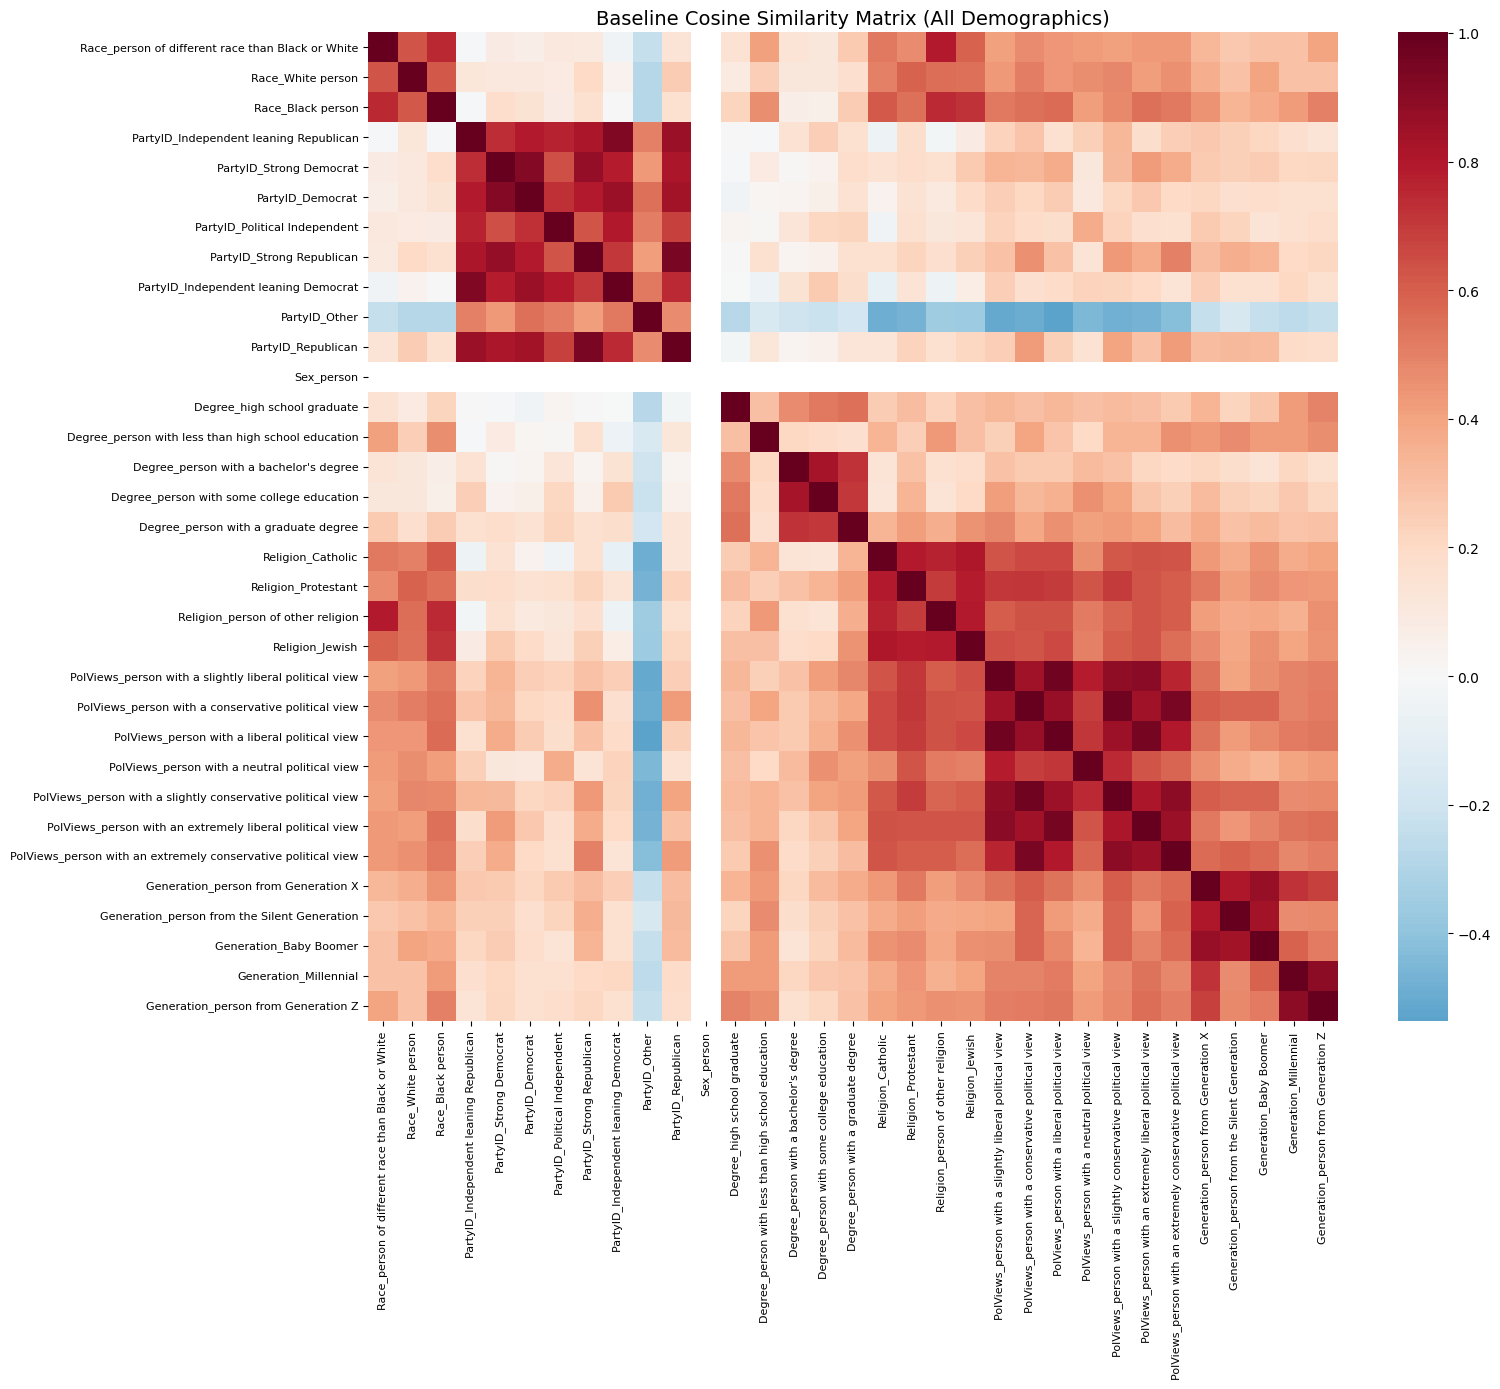

In [6]:
# Visualize baseline similarity matrix
plt.figure(figsize=(16, 14))
sns.heatmap(
    baseline_sim_df,
    cmap='RdBu_r',
    center=0,
    annot=False,
    xticklabels=True,
    yticklabels=True
)
plt.title("Baseline Cosine Similarity Matrix (All Demographics)", fontsize=14)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

## 2. Load Model for Steering Experiments

In [8]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    # The torch_dtype is now handled by bnb_4bit_compute_dtype in BitsAndBytesConfig
    # but keeping it here as it was in the original code, though it might be redundant.
    torch_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

print("Model loaded successfully.")

Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Model loaded successfully.


## 3. Define Steering Functions

In [9]:
def get_activations_with_steering(model, tokenizer, text, layer_idx, steering_vector=None, strength=0.0):
    """
    Get hidden state activations with optional steering vector injection.

    Args:
        model: The LLM model
        tokenizer: Tokenizer
        text: Input text
        layer_idx: Which layer to extract/inject
        steering_vector: Optional steering vector to inject
        strength: Injection strength multiplier

    Returns:
        Hidden state at the last token position
    """
    inputs = tokenizer(text, return_tensors="pt").to(model.device)
    captured_hidden = None

    def hook_fn(module, input, output):
        nonlocal captured_hidden

        if isinstance(output, tuple):
            h_states = output[0]
        else:
            h_states = output

        # Apply steering if provided
        if steering_vector is not None and strength != 0.0:
            steer = steering_vector.to(h_states.device).to(h_states.dtype)
            # Add steering vector to all token positions
            h_states = h_states + strength * steer.unsqueeze(0).unsqueeze(0)

        if h_states.dim() == 3:
            captured_hidden = h_states[0, -1, :].detach().cpu()
        elif h_states.dim() == 2:
            captured_hidden = h_states[-1, :].detach().cpu()

        # Return modified output if steering was applied
        if steering_vector is not None and strength != 0.0:
            if isinstance(output, tuple):
                return (h_states,) + output[1:]
            return h_states
        return output

    layer = model.model.layers[layer_idx]
    handle = layer.register_forward_hook(hook_fn)

    with torch.no_grad():
        model(**inputs)

    handle.remove()
    return captured_hidden

## 4. Measure How Steering Affects Other Demographics

Core experiment: When we steer toward one demographic, measure the similarity change to all other demographics.

In [10]:
def measure_steering_effect(model, tokenizer, demographic_vectors,
                            steering_label, target_layer=10, strength=2.0):
    """
    Measure how steering with one demographic affects similarities to all others.

    Args:
        steering_label: The demographic to steer toward (e.g., 'PartyID_Strong Republican')
        target_layer: Layer to inject steering vector
        strength: Steering strength

    Returns:
        DataFrame with baseline and steered similarities for each demographic
    """
    # Get the steering vector
    steering_vec = demographic_vectors[steering_label]['vector']

    # Test prompt (neutral)
    test_prompt = "[INST] You are a person living in the United States. What are your thoughts on current events? [/INST]"

    # Get baseline activation (no steering)
    baseline_act = get_activations_with_steering(
        model, tokenizer, test_prompt, target_layer,
        steering_vector=None, strength=0.0
    )

    # Get steered activation
    steered_act = get_activations_with_steering(
        model, tokenizer, test_prompt, target_layer,
        steering_vector=steering_vec, strength=strength
    )

    # Measure similarity to all demographic vectors
    results = []

    for label, data in demographic_vectors.items():
        demo_vec = data['vector']

        # Baseline similarity
        baseline_sim = F.cosine_similarity(
            baseline_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        # Steered similarity
        steered_sim = F.cosine_similarity(
            steered_act.unsqueeze(0), demo_vec.unsqueeze(0)
        ).item()

        # Change
        delta = steered_sim - baseline_sim

        results.append({
            'demographic': label,
            'category': label.split('_')[0],
            'baseline_sim': baseline_sim,
            'steered_sim': steered_sim,
            'delta': delta
        })

    return pd.DataFrame(results)

In [11]:
# Run experiment: Steer toward "Strong Republican"
STEERING_DEMOGRAPHIC = "PartyID_Strong Republican"
TARGET_LAYER = 10
STRENGTH = 2.0

print(f"Steering toward: {STEERING_DEMOGRAPHIC}")
print(f"Layer: {TARGET_LAYER}, Strength: {STRENGTH}")

republican_steering_results = measure_steering_effect(
    model, tokenizer, demographic_vectors,
    steering_label=STEERING_DEMOGRAPHIC,
    target_layer=TARGET_LAYER,
    strength=STRENGTH
)

# Sort by delta (biggest changes first)
republican_steering_results = republican_steering_results.sort_values('delta', ascending=False)
republican_steering_results.head(10)

Steering toward: PartyID_Strong Republican
Layer: 10, Strength: 2.0


,demographic,category,baseline_sim,steered_sim,delta
7,PartyID_Strong Republican,PartyID,0.027710,0.392578,0.364868
10,PartyID_Republican,PartyID,0.032074,0.377930,0.345856
4,PartyID_Strong Democrat,PartyID,0.048859,0.366943,0.318085
3,PartyID_Independent leaning Republican,PartyID,0.009598,0.309082,0.299484
5,PartyID_Democrat,PartyID,0.054352,0.342285,0.287933
8,PartyID_Independent leaning Democrat,PartyID,0.019653,0.275879,0.256226
6,PartyID_Political Independent,PartyID,0.014389,0.244995,0.230606
27,PolViews_person with an extremely conservative...,PolViews,-0.037170,0.151001,0.188171
22,PolViews_person with a conservative political ...,PolViews,-0.030777,0.140503,0.171280
25,PolViews_person with a slightly conservative p...,PolViews,-0.022552,0.139526,0.162079


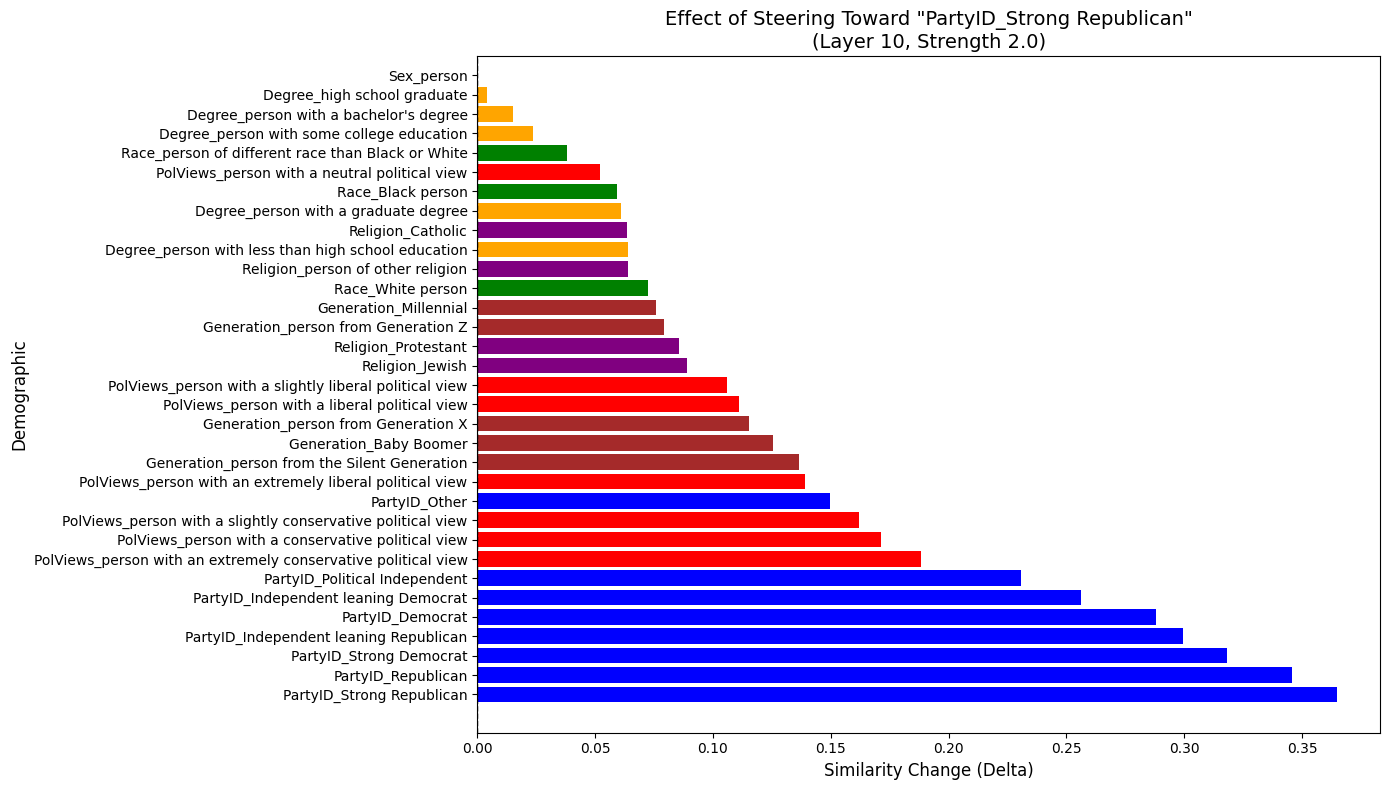

In [12]:
# Visualize: Which demographics move most when steering toward Republican?
plt.figure(figsize=(14, 8))

# Color by category
colors = republican_steering_results['category'].map({
    'PartyID': 'blue',
    'PolViews': 'red',
    'Race': 'green',
    'Religion': 'purple',
    'Degree': 'orange',
    'Generation': 'brown',
    'Sex': 'gray'
}).fillna('black')

plt.barh(
    republican_steering_results['demographic'],
    republican_steering_results['delta'],
    color=colors
)

plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Similarity Change (Delta)', fontsize=12)
plt.ylabel('Demographic', fontsize=12)
plt.title(f'Effect of Steering Toward "{STEERING_DEMOGRAPHIC}"\n(Layer {TARGET_LAYER}, Strength {STRENGTH})', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Compare Multiple Steering Directions

Run the same analysis for different steering demographics to identify patterns.

In [13]:
# List of demographics to test as steering vectors
steering_demographics = [
    "PartyID_Strong Republican",
    "PartyID_Strong Democrat",
    "Race_Black person",
    "Race_White person",
    "PolViews_person with a liberal political view",
    "PolViews_person with a conservative political view",
    "Generation_Millennial",
    "Generation_Baby Boomer"
]

# Collect results for all steering directions
all_steering_results = {}

for steer_demo in steering_demographics:
    print(f"Testing steering: {steer_demo}...")
    results = measure_steering_effect(
        model, tokenizer, demographic_vectors,
        steering_label=steer_demo,
        target_layer=TARGET_LAYER,
        strength=STRENGTH
    )
    all_steering_results[steer_demo] = results

print("\nDone!")

Testing steering: PartyID_Strong Republican...
Testing steering: PartyID_Strong Democrat...
Testing steering: Race_Black person...
Testing steering: Race_White person...
Testing steering: PolViews_person with a liberal political view...
Testing steering: PolViews_person with a conservative political view...
Testing steering: Generation_Millennial...
Testing steering: Generation_Baby Boomer...

Done!


In [14]:
# Build a "Steering Effect Matrix"
# Rows: Steering demographic
# Columns: Affected demographic
# Values: Delta (similarity change)

all_demos = list(demographic_vectors.keys())
effect_matrix = pd.DataFrame(index=steering_demographics, columns=all_demos)

for steer_demo in steering_demographics:
    results_df = all_steering_results[steer_demo]
    for _, row in results_df.iterrows():
        effect_matrix.loc[steer_demo, row['demographic']] = row['delta']

effect_matrix = effect_matrix.astype(float)
effect_matrix.head()

,Race_person of different race than Black or White,Race_White person,Race_Black person,PartyID_Independent leaning Republican,PartyID_Strong Democrat,PartyID_Democrat,PartyID_Political Independent,PartyID_Strong Republican,PartyID_Independent leaning Democrat,PartyID_Other,...,PolViews_person with a liberal political view,PolViews_person with a neutral political view,PolViews_person with a slightly conservative political view,PolViews_person with an extremely liberal political view,PolViews_person with an extremely conservative political view,Generation_person from Generation X,Generation_person from the Silent Generation,Generation_Baby Boomer,Generation_Millennial,Generation_person from Generation Z
PartyID_Strong Republican,0.038288,0.072245,0.059334,0.299484,0.318085,0.287933,0.230606,0.364868,0.256226,0.149658,...,0.110886,0.052231,0.162079,0.138992,0.188171,0.115189,0.136536,0.125351,0.075653,0.079254
PartyID_Strong Democrat,0.030994,0.037851,0.068336,0.267746,0.360321,0.330414,0.233047,0.317261,0.282837,0.155029,...,0.135849,0.044449,0.119659,0.156876,0.136902,0.097183,0.092468,0.095261,0.077576,0.082916
Race_Black person,0.282745,0.230204,0.373634,-0.005264,0.065277,0.050629,0.031052,0.057190,-0.001877,-0.110229,...,0.211349,0.155624,0.180878,0.208145,0.196960,0.166519,0.130005,0.142746,0.159332,0.187653
Race_White person,0.234894,0.370218,0.230202,0.044510,0.035187,0.036896,0.032578,0.071106,0.014679,-0.106842,...,0.163376,0.174423,0.181122,0.156876,0.172546,0.136185,0.112854,0.152451,0.112518,0.109833
PolViews_person with a liberal political view,0.165924,0.163187,0.211525,0.059555,0.134247,0.090057,0.064651,0.109375,0.071899,-0.203369,...,0.374680,0.269638,0.320160,0.359512,0.301819,0.203262,0.161499,0.181686,0.195221,0.202911


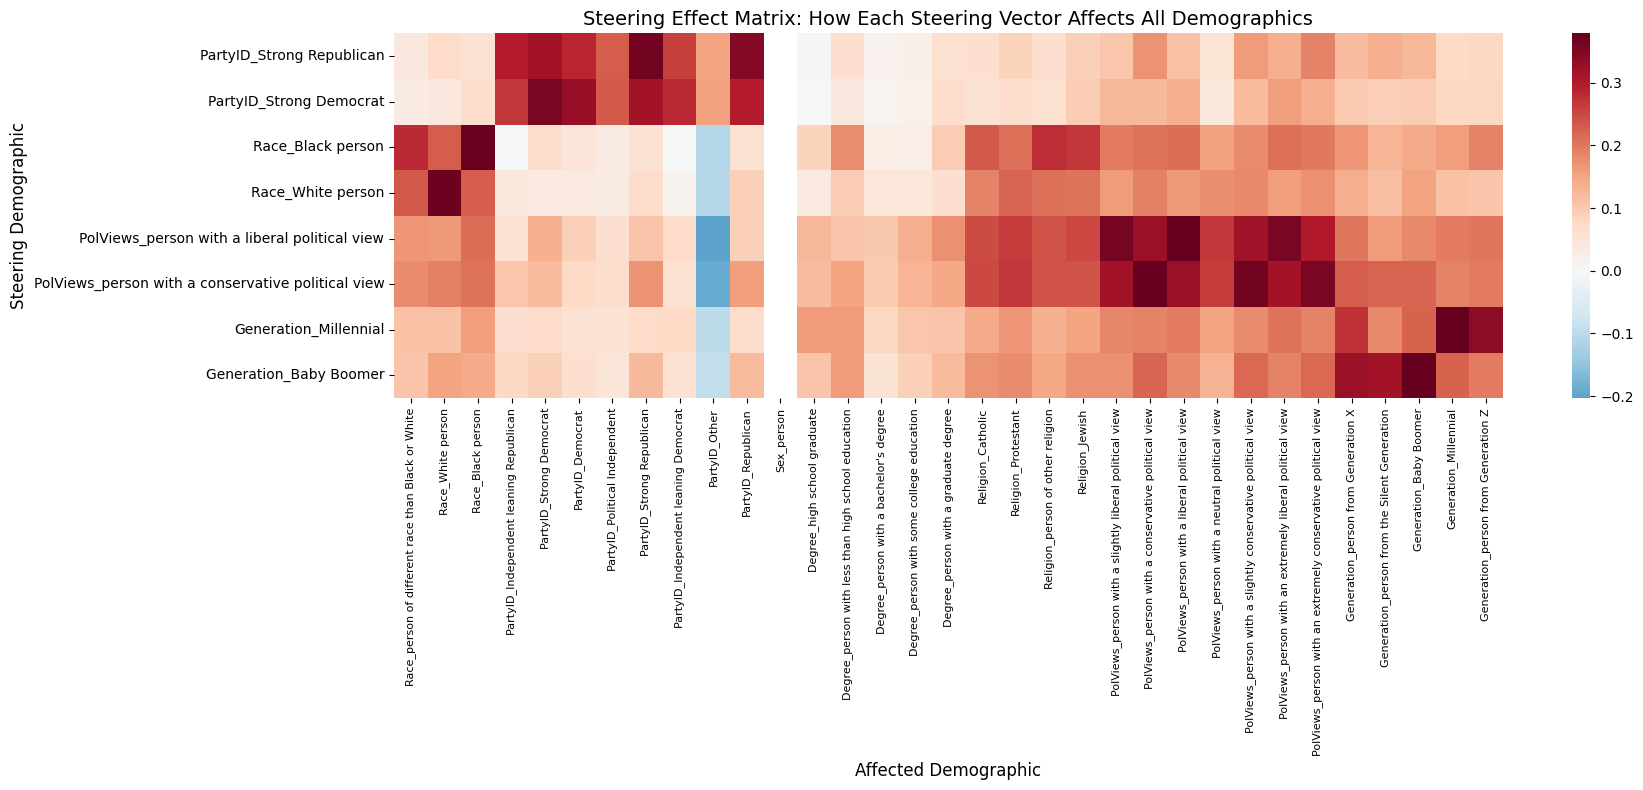

In [15]:
# Visualize the Steering Effect Matrix
plt.figure(figsize=(18, 8))
sns.heatmap(
    effect_matrix,
    cmap='RdBu_r',
    center=0,
    annot=False,
    xticklabels=True,
    yticklabels=True
)
plt.title("Steering Effect Matrix: How Each Steering Vector Affects All Demographics", fontsize=14)
plt.xlabel("Affected Demographic", fontsize=12)
plt.ylabel("Steering Demographic", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## 6. Identify Entangled Demographics

Find pairs of demographics that consistently move together when steering.

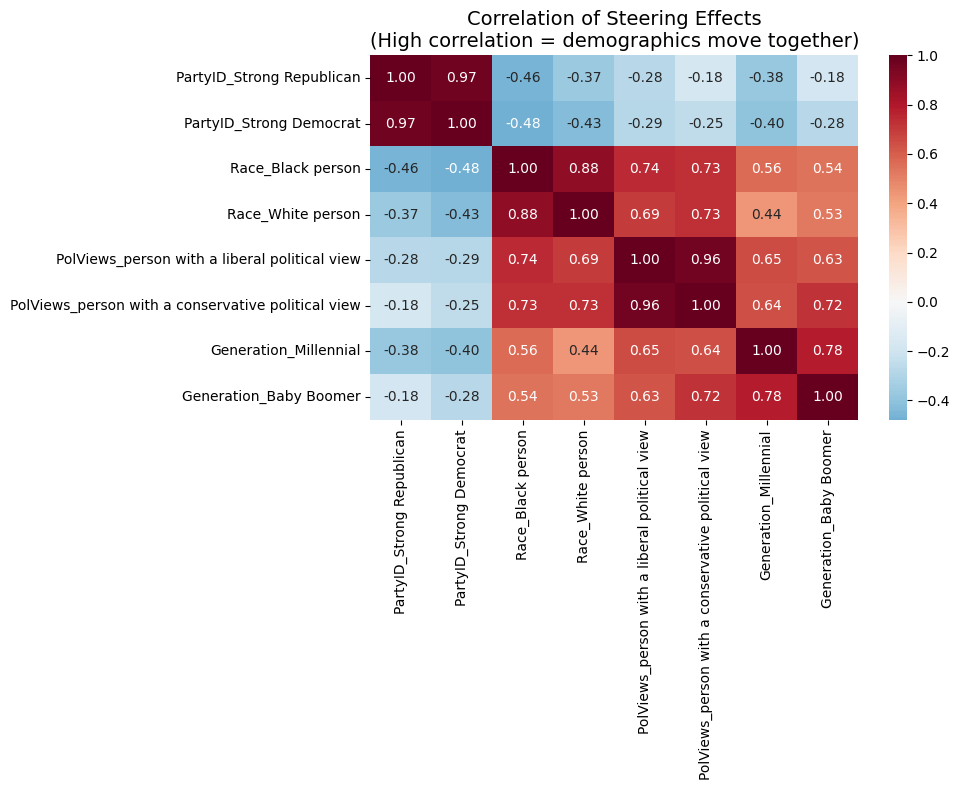

In [16]:
# Compute correlation of steering effects across demographics
# If two demographics always move together, they are "entangled"

effect_correlation = effect_matrix.T.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    effect_correlation,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    xticklabels=True,
    yticklabels=True
)
plt.title("Correlation of Steering Effects\n(High correlation = demographics move together)", fontsize=14)
plt.tight_layout()
plt.show()

In [17]:
# Find most entangled pairs (high positive correlation)
# and most opposing pairs (high negative correlation)

def get_top_pairs(corr_matrix, n=10):
    pairs = []
    labels = corr_matrix.index.tolist()

    for i, label_a in enumerate(labels):
        for j, label_b in enumerate(labels):
            if i < j:  # Avoid duplicates and self-pairs
                corr_val = corr_matrix.loc[label_a, label_b]
                pairs.append((label_a, label_b, corr_val))

    pairs_df = pd.DataFrame(pairs, columns=['Demo_A', 'Demo_B', 'Correlation'])
    return pairs_df.sort_values('Correlation', ascending=False)

steering_pairs = get_top_pairs(effect_correlation)

print("=== MOST ENTANGLED (Move Together) ===")
print(steering_pairs.head(5))

print("\n=== MOST OPPOSING (Move Opposite) ===")
print(steering_pairs.tail(5))

=== MOST ENTANGLED (Move Together) ===
                                           Demo_A  \
0                       PartyID_Strong Republican   
22  PolViews_person with a liberal political view   
13                              Race_Black person   
27                          Generation_Millennial   
14                              Race_Black person   

                                               Demo_B  Correlation  
0                             PartyID_Strong Democrat     0.965999  
22  PolViews_person with a conservative political ...     0.960797  
13                                  Race_White person     0.879005  
27                             Generation_Baby Boomer     0.784501  
14      PolViews_person with a liberal political view     0.740286  

=== MOST OPPOSING (Move Opposite) ===
                       Demo_A                 Demo_B  Correlation
5   PartyID_Strong Republican  Generation_Millennial    -0.375458
11    PartyID_Strong Democrat  Generation_Millennial    -

## 7. Layer Sweep: Find Optimal Layer for Steering Effects

In [18]:
# Test steering effectiveness across layers 10-20
LAYERS_TO_TEST = range(10, 21)
TEST_STEERING = "PartyID_Strong Republican"
TEST_TARGET = "PolViews_person with a conservative political view"  # Should increase

layer_results = []

for layer in LAYERS_TO_TEST:
    print(f"Testing layer {layer}...")
    results = measure_steering_effect(
        model, tokenizer, demographic_vectors,
        steering_label=TEST_STEERING,
        target_layer=layer,
        strength=2.0
    )

    # Get delta for target demographic
    target_row = results[results['demographic'] == TEST_TARGET]
    if len(target_row) > 0:
        delta = target_row['delta'].values[0]
        layer_results.append({'layer': layer, 'delta': delta})

layer_df = pd.DataFrame(layer_results)
print("\nLayer sweep complete!")

Testing layer 10...
Testing layer 11...
Testing layer 12...
Testing layer 13...
Testing layer 14...
Testing layer 15...
Testing layer 16...
Testing layer 17...
Testing layer 18...
Testing layer 19...
Testing layer 20...

Layer sweep complete!


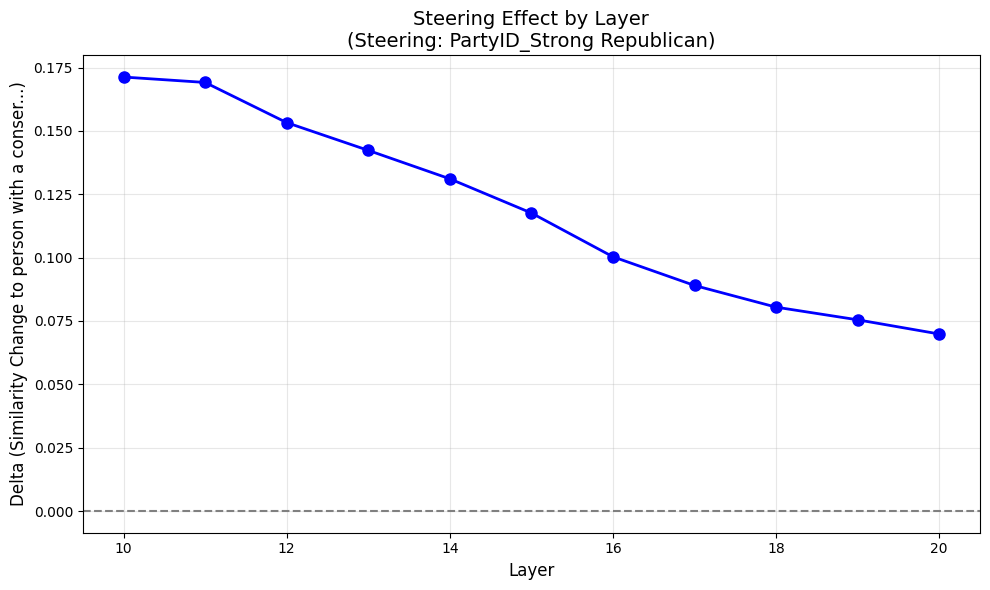


Optimal layer for steering: 10


In [19]:
# Visualize layer sweep
plt.figure(figsize=(10, 6))
plt.plot(layer_df['layer'], layer_df['delta'], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Layer', fontsize=12)
plt.ylabel(f'Delta (Similarity Change to {TEST_TARGET.split("_")[-1][:20]}...)', fontsize=12)
plt.title(f'Steering Effect by Layer\n(Steering: {TEST_STEERING})', fontsize=14)
plt.axhline(y=0, color='gray', linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find best layer
best_layer = layer_df.loc[layer_df['delta'].idxmax(), 'layer']
print(f"\nOptimal layer for steering: {best_layer}")

## 8. Save Results

In [20]:
# Save the steering effect matrix
effect_matrix.to_csv(os.path.join(BASE_DIR, "steering_effect_matrix.csv"))

# Save the layer sweep results
layer_df.to_csv(os.path.join(BASE_DIR, "layer_sweep_results.csv"), index=False)

print("Results saved!")

Results saved!


## Summary

This notebook investigated:

1. **Baseline similarities** between all demographic vectors
2. **Steering effects** - how injecting one demographic vector changes similarities to others
3. **Entanglement patterns** - which demographics move together under steering
4. **Layer optimization** - which layer produces the strongest/cleanest steering effects

Key findings to document:
- Which demographics are most "entangled" with each other?
- Are political views and party ID more entangled than race and party ID?
- What is the optimal layer for steering experiments?